In [11]:
import random
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from pycaret.regression import * 
import warnings
warnings.filterwarnings(action='ignore') 

In [12]:
seed=42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [42]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
building_info = pd.read_csv('./building_info.csv')

In [40]:
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [43]:
from datetime import datetime, timedelta

# 일출과 일몰 시간을 지정된 날짜별로 매핑
sunrise_sunset_times = {
    '20220601': {'sunrise': '05:04', 'sunset': '19:43'},
    '20220616': {'sunrise': '05:02', 'sunset': '19:51'},
    '20220701': {'sunrise': '05:06', 'sunset': '19:53'},
    '20220716': {'sunrise': '05:15', 'sunset': '19:48'},
    '20220801': {'sunrise': '05:27', 'sunset': '19:36'},
    '20220816': {'sunrise': '05:41', 'sunset': '19:19'},
    '20220824': {'sunrise': '05:48', 'sunset': '19:08'},
}

# 날짜와 시간을 파싱하여 해당 날짜의 일출과 일몰 시간을 기준으로 결측치 처리
def fill_night_missing_values(row):
    date_str = row['일시'][:8]
    time_str = row['일시'][9:]
    hour = int(time_str[:2])

    # 일출과 일몰 시간 찾기
    sunrise_time = sunset_time = None
    for key, value in sorted(sunrise_sunset_times.items()):
        if date_str < key:
            break
        sunrise_time = int(value['sunrise'][:2])
        sunset_time = int(value['sunset'][:2])

    # 밤 시간에만 결측치를 0으로 채우기
    if sunrise_time is not None and sunset_time is not None:
        if hour < sunrise_time or hour >= sunset_time:
            row['일조(hr)'] = 0
            row['일사(MJ/m2)'] = 0

    return row

# 결측치 처리 적용
train_df = train_df.apply(fill_night_missing_values, axis=1)

# 처리된 데이터의 처음 5줄 출력
train_df.isna().sum()


num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)             8539
일사(MJ/m2)         19572
전력소비량(kWh)            0
dtype: int64

In [44]:
# 주어진 일출과 일몰 시간을 사용하여 낮 시간대의 "일조량"과 "일사량"에 대해 선형 보간 적용
def interpolate_daytime_values(df, sunrise_sunset_times):
    for date_str, time_data in sunrise_sunset_times.items():
        sunrise_time = int(time_data['sunrise'][:2])
        sunset_time = int(time_data['sunset'][:2])
        
        # 해당 날짜의 데이터만 선택
        mask_date = df['일시'].str.startswith(date_str)
        
        # 일출과 일몰 사이의 시간대만 선택
        mask_time = (df['일시'].str[9:11].astype(int) >= sunrise_time) & \
                    (df['일시'].str[9:11].astype(int) < sunset_time)
        
        # 해당 시간대에 대해 선형 보간 적용
        df.loc[mask_date & mask_time, ['일조(hr)', '일사(MJ/m2)']] = \
            df.loc[mask_date & mask_time, ['일조(hr)', '일사(MJ/m2)']].interpolate(method='linear')
    
    # 나머지 값에 대해 앞뒤 값으로 채우기
    df['일조(hr)'] = df['일조(hr)'].fillna(method='ffill').fillna(method='bfill')
    df['일사(MJ/m2)'] = df['일사(MJ/m2)'].fillna(method='ffill').fillna(method='bfill')

    return df

# 낮 시간의 "일조량"과 "일사량" 결측치에 대해 선형 보간 적용
train_df = interpolate_daytime_values(train_df, sunrise_sunset_times)

# 결측치 확인
train_df.isna().sum()


num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)                0
일사(MJ/m2)             0
전력소비량(kWh)            0
dtype: int64

In [45]:
train_df.drop('num_date_time', axis = 1, inplace=True)
test_df.drop('num_date_time', axis = 1, inplace=True)

In [46]:
# Merge training data with building info
train_df = pd.merge(train_df, building_info, how='left', on='건물번호')
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

# date time feature 생성
train_df['시'] = train_df['일시'].dt.hour
train_df['일'] = train_df['일시'].dt.day
train_df['월'] = train_df['일시'].dt.month
train_df['연도'] = train_df['일시'].dt.year

In [61]:
test_df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1,20220825 00,23.5,0.0,2.2,72
1,1,20220825 01,23.0,0.0,0.9,72
2,1,20220825 02,22.7,0.0,1.5,75
3,1,20220825 03,22.1,0.0,1.3,78
4,1,20220825 04,21.8,0.0,1.0,77


In [47]:
# Sort the training data by '일시'
train_df.sort_values('일시', inplace=True)

# Calculate the average '풍속(m/s)'
average_wind_speed = train_df['풍속(m/s)'].mean()

# Fill the missing values in '풍속(m/s)' with the average wind speed
train_df['풍속(m/s)'].fillna(average_wind_speed, inplace=True)

In [48]:
# Count the number of NaN values in '일조(hr)' and '일사(MJ/m2)' for each unique time
nan_counts_sunshine = train_df[train_df['일조(hr)'].isna()]['시'].value_counts().sort_index()
nan_counts_radiation = train_df[train_df['일사(MJ/m2)'].isna()]['시'].value_counts().sort_index()

nan_counts = pd.DataFrame({
    'Time': nan_counts_sunshine.index,
    '일조(hr) NaN Count': nan_counts_sunshine.values,
    '일사(MJ/m2) NaN Count': nan_counts_radiation.values
})

nan_counts

,Time,일조(hr) NaN Count,일사(MJ/m2) NaN Count


In [27]:
((train_df['일조(hr)'] == 0.0)&(train_df['시']==1)).unique()

array([False,  True])

In [28]:
train_df.isna().sum()

건물번호                 0
일시                   0
기온(C)                0
강수량(mm)         160069
풍속(m/s)              0
습도(%)                9
일조(hr)           75182
일사(MJ/m2)        87913
전력소비량(kWh)           0
건물유형                 0
연면적(m2)              0
냉방면적(m2)             0
태양광용량(kW)            0
ESS저장용량(kWh)         0
PCS용량(kW)            0
시                    0
일                    0
월                    0
연도                   0
dtype: int64

In [29]:
(train_df['강수량(mm)']== (0. )).count()

204000

In [49]:
# Forward and backward fill '습도(%)' for each hour
train_df['습도(%)'] = train_df.groupby('시')['습도(%)'].fillna(method='ffill').fillna(method='bfill')

# Check the number of missing values in '습도(%)' after filling
missing_humidity_after_filling = train_df['습도(%)'].isnull().sum()

# # Fill the missing values in '강수량(mm)' with 0
# train_df['강수량(mm)'].fillna(0, inplace=True)

In [50]:
train_df.isna().sum()

건물번호                 0
일시                   0
기온(C)                0
강수량(mm)         160069
풍속(m/s)              0
습도(%)                0
일조(hr)               0
일사(MJ/m2)            0
전력소비량(kWh)           0
건물유형                 0
연면적(m2)              0
냉방면적(m2)             0
태양광용량(kW)            0
ESS저장용량(kWh)         0
PCS용량(kW)            0
시                    0
일                    0
월                    0
연도                   0
dtype: int64

In [15]:
# Drop '일조(hr)' and '일사(MJ/m2)' from the training data
train_df.drop(['일조(hr)', '일사(MJ/m2)'], axis=1, inplace=True)

In [66]:
train_df.isna().sum()

일시                   0
건물번호                 0
기온(C)                0
강수량(mm)         160069
풍속(m/s)              0
습도(%)                0
일조(hr)               0
일사(MJ/m2)            0
전력소비량(kWh)           0
건물유형                 0
연면적(m2)              0
냉방면적(m2)             0
태양광용량(kW)            0
ESS저장용량(kWh)         0
PCS용량(kW)            0
시                    0
일                    0
월                    0
연도                   0
dtype: int64

In [51]:
train_df.drop('연도', axis = 1, inplace=True)
#train_df.reset_index(drop=True, inplace=True)

In [35]:
train_temp=train_df
train_df = train_temp

In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

# Prepare data
features = ['기온(C)', '풍속(m/s)', '습도(%)']
X = train_df[features + ['강수량(mm)']]

rf_imputer = IterativeImputer(RandomForestRegressor(n_estimators=10, random_state=42))
X_rf_imputed = rf_imputer.fit_transform(X)

# Create a DataFrame from the imputed data
imputed_df = pd.DataFrame(X_rf_imputed, columns=features + ['강수량(mm)'])

# Replace the '강수량(mm)' column in the original DataFrame with the imputed data
train_df['강수량(mm)'] = imputed_df['강수량(mm)']

In [24]:
train_df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월
0,1,2022-06-01,18.6,0.00,0.9,42.0,1085.28,건물기타,110634.000,39570.00,-,-,-,0,1,6
142800,71,2022-06-01,18.5,0.00,1.9,38.0,1384.56,연구소,90896.000,44536.00,65,3100,800,0,1,6
140760,70,2022-06-01,18.5,0.00,1.9,38.0,3237.88,연구소,141014.000,120000.00,28.44,-,-,0,1,6
138720,69,2022-06-01,18.6,0.00,0.9,42.0,3269.10,연구소,139928.730,111183.19,14.4,-,-,0,1,6
136680,68,2022-06-01,18.6,0.04,0.9,42.0,1540.20,아파트,389395.928,0.00,-,-,-,0,1,6


In [53]:
train_df.reset_index(drop=True, inplace=True)

In [54]:
train_df.isna().sum()

건물번호            0
일시              0
기온(C)           0
강수량(mm)         0
풍속(m/s)         0
습도(%)           0
일조(hr)          0
일사(MJ/m2)       0
전력소비량(kWh)      0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
시               0
일               0
월               0
dtype: int64

In [55]:
# Merge training data with building info
test_df = pd.merge(test_df, building_info, how='left', on='건물번호')
test_df['일시'] = pd.to_datetime(test_df['일시'], format='%Y%m%d %H')

# date time feature 생성
test_df['시'] = test_df['일시'].dt.hour
test_df['일'] = test_df['일시'].dt.day
test_df['월'] = test_df['일시'].dt.month
test_df['연도'] = test_df['일시'].dt.year

In [33]:
test_df.head()

,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,연도
0,1,2022-08-25 00:00:00,23.5,0.0,2.2,72,건물기타,110634.0,39570.0,-,-,-,0,25,8,2022
1,1,2022-08-25 01:00:00,23.0,0.0,0.9,72,건물기타,110634.0,39570.0,-,-,-,1,25,8,2022
2,1,2022-08-25 02:00:00,22.7,0.0,1.5,75,건물기타,110634.0,39570.0,-,-,-,2,25,8,2022
3,1,2022-08-25 03:00:00,22.1,0.0,1.3,78,건물기타,110634.0,39570.0,-,-,-,3,25,8,2022
4,1,2022-08-25 04:00:00,21.8,0.0,1.0,77,건물기타,110634.0,39570.0,-,-,-,4,25,8,2022


In [56]:
train_df.drop('일시', axis=1,inplace=True)

In [57]:
test_df.drop('연도', axis = 1, inplace=True)
test_df.drop('일시', axis = 1, inplace=True)

In [22]:
train_df.columns

Index(['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '전력소비량(kWh)', '건물유형',
       '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '시',
       '일', '월'],
      dtype='object')

In [23]:
test_df.columns

Index(['건물번호', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '건물유형', '연면적(m2)',
       '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', '시', '일', '월'],
      dtype='object')

In [53]:
test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월
0,1,23.5,0.0,2.2,72,건물기타,110634.0,39570.0,-,-,-,0,25,8
1,1,23.0,0.0,0.9,72,건물기타,110634.0,39570.0,-,-,-,1,25,8
2,1,22.7,0.0,1.5,75,건물기타,110634.0,39570.0,-,-,-,2,25,8
3,1,22.1,0.0,1.3,78,건물기타,110634.0,39570.0,-,-,-,3,25,8
4,1,21.8,0.0,1.0,77,건물기타,110634.0,39570.0,-,-,-,4,25,8


In [58]:
# Handle missing values
train_df.fillna({'태양광용량(kW)': 'None', 'ESS저장용량(kWh)': 'None', 'PCS용량(kW)': 'None'}, inplace=True)

# # Convert categorical column '건물유형' into numerical values using one-hot encoding
# train_df = pd.get_dummies(train_df, columns=['건물유형'])
le = LabelEncoder()

# Apply LabelEncoder to '건물유형' column
train_df['건물유형'] = le.fit_transform(train_df['건물유형'])
test_df['건물유형'] = le.transform(test_df['건물유형'])
# Create new features
train_df['냉방면적비율'] = train_df['냉방면적(m2)'] / train_df['연면적(m2)']  # The ratio of the cooling area to the total floor area
train_df['기온습도'] = train_df['기온(C)'] * train_df['습도(%)']  # The interaction between temperature and humidity

train_df.head()


,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,냉방면적비율,기온습도
0,1,18.6,0.00,0.9,42.0,0.0,0.0,1085.28,0,110634.000,39570.00,-,-,-,0,1,6,0.357666,781.2
1,71,18.5,0.00,1.9,38.0,0.0,0.0,1384.56,8,90896.000,44536.00,65,3100,800,0,1,6,0.489967,703.0
2,70,18.5,0.00,1.9,38.0,0.0,0.0,3237.88,8,141014.000,120000.00,28.44,-,-,0,1,6,0.850979,703.0
3,69,18.6,0.00,0.9,42.0,0.0,0.0,3269.10,8,139928.730,111183.19,14.4,-,-,0,1,6,0.794570,781.2
4,68,18.6,0.06,0.9,42.0,0.0,0.0,1540.20,7,389395.928,0.00,-,-,-,0,1,6,0.000000,781.2


In [59]:
test_df.fillna({'강수량(mm)': 0, '일조(hr)': 0, '일사(MJ/m2)': 0, '태양광용량(kW)': 'None', 'ESS저장용량(kWh)': 'None', 'PCS용량(kW)': 'None'}, inplace=True)

# Create new features
test_df['냉방면적비율'] = test_df['냉방면적(m2)'] / test_df['연면적(m2)']  # The ratio of the cooling area to the total floor area
test_df['기온습도'] = test_df['기온(C)'] * test_df['습도(%)']  # The interaction between temperature and humidity

test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월,냉방면적비율,기온습도
0,1,23.5,0.0,2.2,72,0,110634.0,39570.0,-,-,-,0,25,8,0.357666,1692.0
1,1,23.0,0.0,0.9,72,0,110634.0,39570.0,-,-,-,1,25,8,0.357666,1656.0
2,1,22.7,0.0,1.5,75,0,110634.0,39570.0,-,-,-,2,25,8,0.357666,1702.5
3,1,22.1,0.0,1.3,78,0,110634.0,39570.0,-,-,-,3,25,8,0.357666,1723.8
4,1,21.8,0.0,1.0,77,0,110634.0,39570.0,-,-,-,4,25,8,0.357666,1678.6


In [60]:
import numpy as np

# Replace '-' with np.nan and then fillna with 0
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    train_df[col] = train_df[col].replace('-', np.nan).fillna(0).astype(float)

# Check the dtypes again
train_df.dtypes

# Replace '-' with np.nan and then fillna with 0
for col in ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']:
    test_df[col] = test_df[col].replace('-', np.nan).fillna(0).astype(float)

# Check the dtypes again
test_df.dtypes

건물번호              int64
기온(C)           float64
강수량(mm)         float64
풍속(m/s)         float64
습도(%)             int64
건물유형              int32
연면적(m2)         float64
냉방면적(m2)        float64
태양광용량(kW)       float64
ESS저장용량(kWh)    float64
PCS용량(kW)       float64
시                 int64
일                 int64
월                 int64
냉방면적비율          float64
기온습도            float64
dtype: object

In [39]:
train_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월
0,1,18.6,0.00,0.9,42.0,1085.28,0,110634.000,39570.00,0.00,0.0,0.0,0,1,6
1,71,18.5,0.00,1.9,38.0,1384.56,8,90896.000,44536.00,65.00,3100.0,800.0,0,1,6
2,70,18.5,0.00,1.9,38.0,3237.88,8,141014.000,120000.00,28.44,0.0,0.0,0,1,6
3,69,18.6,0.00,0.9,42.0,3269.10,8,139928.730,111183.19,14.40,0.0,0.0,0,1,6
4,68,18.6,0.04,0.9,42.0,1540.20,7,389395.928,0.00,0.00,0.0,0.0,0,1,6


In [40]:
test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW),시,일,월
0,1,23.5,0.0,2.2,72,0,110634.0,39570.0,0.0,0.0,0.0,0,25,8
1,1,23.0,0.0,0.9,72,0,110634.0,39570.0,0.0,0.0,0.0,1,25,8
2,1,22.7,0.0,1.5,75,0,110634.0,39570.0,0.0,0.0,0.0,2,25,8
3,1,22.1,0.0,1.3,78,0,110634.0,39570.0,0.0,0.0,0.0,3,25,8
4,1,21.8,0.0,1.0,77,0,110634.0,39570.0,0.0,0.0,0.0,4,25,8


In [61]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output


In [62]:
# Define features and target again after preprocessing
X = train_df.drop('전력소비량(kWh)', axis=1)
y = train_df['전력소비량(kWh)']
model = setup(X, target = y, session_id=seed )
# SMAPE를 pycaret 지표로 추가
from pycaret.regression import add_metric
add_metric('smape', 'SMAPE', smape, greater_is_better=False)

,Description,Value
0,Session id,42
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 19)"
4,Transformed data shape,"(204000, 19)"
5,Transformed train set shape,"(142800, 19)"
6,Transformed test set shape,"(61200, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


Name                                                       SMAPE
Display Name                                               SMAPE
Score Function            <function smape at 0x00000259187C6E50>
Scorer               make_scorer(smape, greater_is_better=False)
Target                                                      pred
Args                                                          {}
Greater is Better                                          False
Custom                                                      True
Name: smape, dtype: object

In [63]:
top5_models = compare_models(fold = 5, round = 3, sort = 'smape', n_select = 3)
top5_models

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE,TT (Sec)
et,Extra Trees Regressor,173.476,136059.200,368.811,0.977,0.145,0.086,7.810,4.620
rf,Random Forest Regressor,179.279,147865.484,384.385,0.975,0.148,0.089,8.029,6.836
dt,Decision Tree Regressor,212.252,291156.983,539.463,0.951,0.199,0.103,9.588,0.258
catboost,CatBoost Regressor,234.062,157168.372,396.384,0.974,0.198,0.133,12.299,3.192
xgboost,Extreme Gradient Boosting,235.825,158551.225,398.148,0.974,0.204,0.134,12.465,1.360
lightgbm,Light Gradient Boosting Machine,300.757,227160.158,476.556,0.962,0.226,0.174,15.392,0.288
knn,K Neighbors Regressor,457.947,578623.162,760.586,0.904,0.338,0.266,21.831,1.694
gbr,Gradient Boosting Regressor,534.514,563553.039,750.652,0.906,0.376,0.341,26.877,2.818
lasso,Lasso Regression,1344.703,5224124.200,2285.115,0.130,0.725,0.803,52.832,0.768
ridge,Ridge Regression,1341.414,5219398.900,2284.080,0.131,0.734,0.800,52.962,0.522


Processing:   0%|          | 0/87 [00:00<?, ?it/s]

[ExtraTreesRegressor(n_jobs=-1, random_state=42),
 RandomForestRegressor(n_jobs=-1, random_state=42),
 DecisionTreeRegressor(random_state=42)]

In [64]:
total_models = []
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [66]:
et = create_model('et',fold=10)
total_models.append(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,167.9274,126357.8315,355.4685,0.9796,0.1433,0.0852,7.6442
1,169.2893,130528.8185,361.2877,0.9779,0.1387,0.0830,7.5530
2,168.8064,128675.2655,358.7133,0.9794,0.1524,0.0838,7.6187
3,170.2692,135586.9191,368.2213,0.9785,0.1392,0.0828,7.5567
4,173.5475,143505.1790,378.8208,0.9740,0.1422,0.0851,7.6817
5,165.3841,120370.9052,346.9451,0.9794,0.1359,0.0817,7.4730
6,168.6352,128002.1068,357.7738,0.9788,0.1425,0.0848,7.6765
7,167.5472,129872.5097,360.3783,0.9802,0.1386,0.0827,7.5583
8,166.0118,121561.0971,348.6561,0.9795,0.1410,0.0831,7.5746


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [67]:
rf = create_model('rf', fold = 10)
total_models.append(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,172.4738,135805.1516,368.5175,0.9780,0.1458,0.0871,7.8229
1,173.4683,137603.1165,370.9489,0.9767,0.1415,0.0852,7.7277
2,175.1719,140861.5387,375.3153,0.9774,0.1556,0.0870,7.8669
3,174.4449,148941.9545,385.9300,0.9764,0.1413,0.0843,7.6849
4,179.6430,156016.2210,394.9889,0.9717,0.1445,0.0877,7.9354
5,171.1740,132328.0707,363.7693,0.9774,0.1381,0.0840,7.6844
6,175.2849,145477.8331,381.4156,0.9759,0.1461,0.0877,7.9123
7,174.0423,145888.0273,381.9529,0.9777,0.1410,0.0851,7.7756
8,169.0027,125261.5234,353.9230,0.9788,0.1419,0.0849,7.7176


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [68]:
boosted_rf = ensemble_model(rf, fold = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,192.7202,160052.3318,400.0654,0.9741,0.1553,0.0962,8.5721
1,192.8505,158977.2353,398.7195,0.9731,0.1518,0.0943,8.4647
2,196.0849,164672.5527,405.7987,0.9736,0.1662,0.0968,8.6630
3,194.2891,169918.4525,412.2117,0.9731,0.1521,0.0941,8.4643
4,198.7839,179366.8376,423.5172,0.9675,0.1555,0.0968,8.6680
5,191.5090,155906.9361,394.8505,0.9733,0.1483,0.0932,8.4436
6,194.7923,164638.5814,405.7568,0.9727,0.1564,0.0971,8.6580
7,192.7245,166155.5020,407.6218,0.9747,0.1499,0.0933,8.4518
8,188.2146,145729.8503,381.7458,0.9754,0.1511,0.0935,8.4396


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [69]:
boosted_et = ensemble_model(et, fold=7)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
1,186.8439,148885.1138,385.8563,0.9756,0.1577,0.0922,8.2743
2,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
3,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
4,187.4640,149712.7307,386.9273,0.9757,0.1513,0.0928,8.3183
5,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
6,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000
Mean,53.4725,42656.8349,110.3977,0.2787,0.0442,0.0264,2.3704
Std,84.5477,67446.7408,174.5543,0.4407,0.0698,0.0418,3.7479


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [70]:
blender3 = blend_models(estimator_list=[et ,rf])

,MAE,MSE,RMSE,R2,RMSLE,MAPE,SMAPE
Fold,,,,,,,
0,167.6855,126124.7553,355.1405,0.9796,0.1425,0.0849,7.6196
1,169.0913,129583.5020,359.9771,0.9781,0.1381,0.0830,7.5328
2,169.5978,129264.5813,359.5338,0.9793,0.1520,0.0843,7.6411
3,169.9435,136890.0861,369.9866,0.9783,0.1381,0.0824,7.5099
4,174.2267,145088.2116,380.9045,0.9737,0.1414,0.0852,7.6993
5,166.0207,121597.2702,348.7080,0.9792,0.1349,0.0817,7.4718
6,169.4699,131960.4812,363.2637,0.9781,0.1423,0.0850,7.6831
7,168.5943,132855.0059,364.4928,0.9797,0.1379,0.0829,7.5662
8,165.1963,118872.8224,344.7794,0.9799,0.1395,0.0829,7.5370


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [33]:
model_rf = tune_model(rf, fold=10, optimize = 'smape', choose_better = True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:34:14
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

In [71]:
final_model = finalize_model(blender3) # 모델 선택

In [72]:
prediction = predict_model(final_model, data = test_df)
prediction.head()

KeyError: "['일조(hr)', '일사(MJ/m2)'] not in index"

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['answer'] = prediction['prediction_label']
submission

,num_date_time,answer
0,1_20220825 00,2078.025360
1,1_20220825 01,2039.870386
2,1_20220825 02,2004.258248
3,1_20220825 03,1979.491207
4,1_20220825 04,1964.174889
...,...,...
16795,100_20220831 19,915.772800
16796,100_20220831 20,888.290279
16797,100_20220831 21,806.011438
16798,100_20220831 22,701.895188


In [61]:
submission.head()

,num_date_time,answer
0,1_20220825 00,2075.855520
1,1_20220825 01,2042.039985
2,1_20220825 02,2003.452806
3,1_20220825 03,1984.110247
4,1_20220825 04,1964.411050


In [ ]:
submission.to_csv('./sample_submission.csv', index=False)

883050 sample_submission.csv ->     2023-08-04 22:56:28	  
점수 :  11.3106350099    
882357	baseline_submission.csv -> 기본 베이스라인    
점수 :  11.4272466862      
883068	sample_submission.csv -> 냉방면적비율, 기온 * 습도   
점수 :  11.0962158216   
883089  sample_submission.csv -> rf,et두개 튜닝 없이 blend, 위의 피처 유지   
점수 :  10.5175166528  
883972	sample_submission.csv -> rf, et, dt 3개 튜닝 없이 blend, 피처 유지  
점수 :  11.0865256548   
883996	sample_submission.csv -> rf boosting   
점수 :  10.7427858361   
884099	sample_submission.csv -> 일사, 일조 저녁 NaN처리, rf 사용  
점수 :  11.1980426119   
884104	sample_submission.csv -> rf, et blend  
점수 :  10.6167324479   
884131	sample_submission.csv -> rf boosting  
점수 :  10.783522939  

### 밤 시간대는 0, 낮은 선형 보간 및 양쪽 값으로 일조, 일사 결측치 채움   
rf   
점수 :  11.0883508279  
rf, et blend  
점수 :  10.522504182  
rf boosting  
점수 :  10.7291229483  

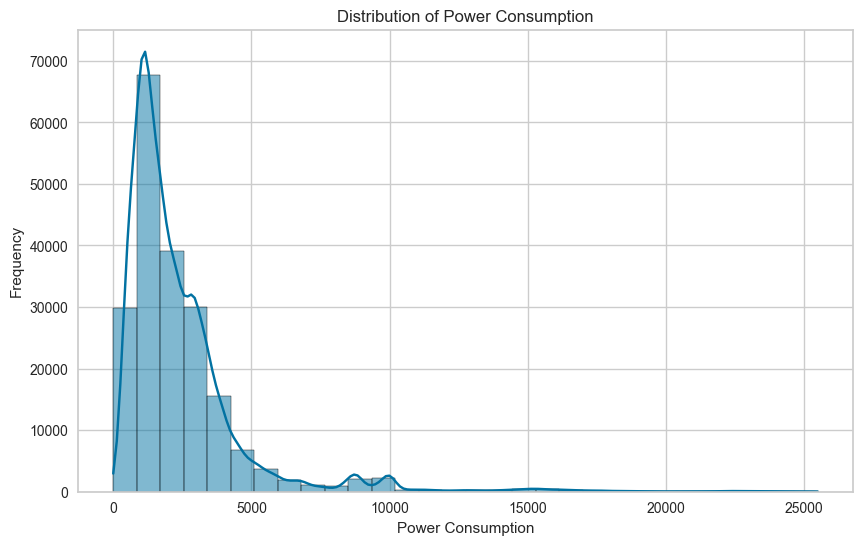

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train_df['전력소비량(kWh)'], bins=30, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.show()

In [53]:
test_df.head()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),시,일,월
0,1,23.5,0.0,2.2,72,0,25,8
1,1,23.0,0.0,0.9,72,1,25,8
2,1,22.7,0.0,1.5,75,2,25,8
3,1,22.1,0.0,1.3,78,3,25,8
4,1,21.8,0.0,1.0,77,4,25,8


In [7]:
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [8]:
building_info['건물유형'].unique()

array(['건물기타', '공공', '대학교', '데이터센터', '백화점및아울렛', '병원', '상용', '아파트', '연구소',
       '지식산업센터', '할인마트', '호텔및리조트'], dtype=object)

In [12]:
building_info.isnull().sum()

건물번호            0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
dtype: int64

In [13]:
train_df.isnull().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

In [25]:
(train_df['일조(hr)'].isna()&train_df['일사(MJ/m2)'].notna()).sum()

1

일조 데이터가 null이면서 일사 데이터가 null이 아닌 데이터는 한개뿐

In [26]:
(train_df['일조(hr)'].isna()&train_df['일사(MJ/m2)'].isna()).sum()

75181